# Build a model to detect if Randall is in the image or not!

Randall or Not

## Dataset
   
- Randall : s3://ranman-selfies
- Not Randall: http://vis-www.cs.umass.edu/lfw/lfw.tgz  (celeb faces)
    

### most of the code is borrowed from
https://github.com/dmlc/mxnet-notebooks/blob/master/python/tutorials/finetune-CNN-catsvsdogs.ipynb

In [1]:
# helper functions
import mxnet as mx
import os, urllib

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.urlretrieve(url, filename)
        
def get_model(prefix, epoch):
    download(prefix+'-symbol.json')
    download(prefix+'-%04d.params' % (epoch,))

get_model('http://data.mxnet.io/models/imagenet/resnet/152-layers/resnet-152', 0)
sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-152', 0)

In [2]:
# Data Iterators for cats vs dogs dataset

import mxnet as mx

def get_iterators(batch_size, data_shape=(3, 224, 224)):
    train = mx.io.ImageRecordIter(
        path_imgrec         = './data/rnr_train.lst.rec', 
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        shuffle             = True,
        rand_crop           = True,
        rand_mirror         = True)
    val = mx.io.ImageRecordIter(
        path_imgrec         = './data/rnr_valid.lst.rec',
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        rand_crop           = False,
        rand_mirror         = False)
    return (train, val)

In [3]:
def get_fine_tune_model(symbol, arg_params, num_classes, layer_name='flatten0'):
    """
    symbol: the pre-trained network symbol
    arg_params: the argument parameters of the pre-trained model
    num_classes: the number of classes for the fine-tune datasets
    layer_name: the layer name before the last fully-connected layer
    """
    all_layers = sym.get_internals()
    net = all_layers[layer_name + '_output']
    net = mx.symbol.FullyConnected(data=net, num_hidden=num_classes, name='fc1')
    net = mx.symbol.SoftmaxOutput(data=net, name='softmax')
    new_args = dict({k:arg_params[k] for k in arg_params if 'fc1' not in k})
    return (net, new_args)

num_classes = 2 # RANDALL OR NOT
(new_sym, new_args) = get_fine_tune_model(sym, arg_params, num_classes)

In [4]:
import logging
head = '%(asctime)-15s %(message)s'
logging.basicConfig(level=logging.DEBUG, format=head)

def fit(symbol, arg_params, aux_params, train, val, batch_size, num_gpus=1, num_epoch=1):
    devs = [mx.gpu(i) for i in range(num_gpus)] # replace mx.gpu by mx.cpu for CPU training
    mod = mx.mod.Module(symbol=new_sym, context=devs)
    mod.bind(data_shapes=train.provide_data, label_shapes=train.provide_label)
    mod.init_params(initializer=mx.init.Xavier(rnd_type='gaussian', factor_type="in", magnitude=2))
    mod.set_params(new_args, aux_params, allow_missing=True)
    mod.fit(train, val, 
        num_epoch=num_epoch,
        batch_end_callback = mx.callback.Speedometer(batch_size, 10),        
        kvstore='device',
        optimizer='sgd',
        optimizer_params={'learning_rate':0.009},
        eval_metric='acc')
    
    return mod

In [5]:
num_classes = 2 # This is binary classification (Randall vs not Randall)
batch_per_gpu = 16
num_gpus = 4
(new_sym, new_args) = get_fine_tune_model(sym, arg_params, num_classes)

batch_size = batch_per_gpu * num_gpus
(train, val) = get_iterators(batch_size)
mod = fit(new_sym, new_args, aux_params, train, val, batch_size, num_gpus)

#metric = mx.metric.Accuracy()
#mod_score = mod.score(val, metric)
#print mod_score

2017-09-07 20:48:08,544 Already bound, ignoring bind()
/home/ubuntu/mxnet/python/mxnet/module/base_module.py:449: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)
2017-09-07 20:48:22,861 Epoch[0] Batch [10]	Speed: 76.39 samples/sec	Train-accuracy=0.850852
2017-09-07 20:48:31,228 Epoch[0] Batch [20]	Speed: 76.50 samples/sec	Train-accuracy=0.967187
2017-09-07 20:48:39,613 Epoch[0] Batch [30]	Speed: 76.34 samples/sec	Train-accuracy=0.981250
2017-09-07 20:48:48,034 Epoch[0] Batch [40]	Speed: 76.02 samples/sec	Train-accuracy=0.992188
2017-09-07 20:48:56,484 Epoch[0] Batch [50]	Speed: 75.74 samples/sec	Train-accuracy=0.985938
2017-09-07 20:49:04,923 Epoch[0] Batch [60]	Speed: 75.85 samples/sec	Train-accuracy=0.987500
2017-09-07 20:49:13,375 Epoch[0] Batch [70]	Speed: 75.73 samples/sec	Train-accuracy=0.990625
2017-09-07 20:49:21,834 Epoch[0] Batch [80]	Speed: 75.67 samples/sec	Train-accuracy=0.993

In [6]:
prefix = 'resnet-mxnet-rnr'
epoch = 1
mc = mod.save_checkpoint(prefix, epoch)

2017-09-07 20:56:10,875 Saved checkpoint to "resnet-mxnet-rnr-0001.params"


In [7]:
# load the model, make sure you have executed previous cells to train
import cv2
dshape = [('data', (1,3,224,224))]

def load_model(s_fname, p_fname):
    """
    Load model checkpoint from file.
    :return: (arg_params, aux_params)
    arg_params : dict of str to NDArray
        Model parameter, dict of name to NDArray of net's weights.
    aux_params : dict of str to NDArray
        Model parameter, dict of name to NDArray of net's auxiliary states.
    """
    symbol = mx.symbol.load(s_fname)
    save_dict = mx.nd.load(p_fname)
    arg_params = {}
    aux_params = {}
    for k, v in save_dict.items():
        tp, name = k.split(':', 1)
        if tp == 'arg':
            arg_params[name] = v
        if tp == 'aux':
            aux_params[name] = v
    return symbol, arg_params, aux_params

model_symbol = "resnet-mxnet-rnr-symbol.json"
model_params = "resnet-mxnet-rnr-0001.params"
sym, arg_params, aux_params = load_model(model_symbol, model_params)
mod = mx.mod.Module(symbol=sym)

# bind the model and set training == False; Define the data shape
mod.bind(for_training=False, data_shapes=dshape)
mod.set_params(arg_params, aux_params)

/home/ubuntu/mxnet/python/mxnet/module/base_module.py:64: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


Lets see if we can predict if that's a Randall image

<img src="https://d0.awsstatic.com/Developer%20Marketing/evangelists/evangelist-bio-randall-hunt.png"/>


In [24]:
import urllib2
import numpy as np

from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def preprocess_image(img, show_img=False):
    '''
    convert the image to a numpy array
    '''
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) 
    img = img[np.newaxis, :] 
    return img

url = 'https://d0.awsstatic.com/Developer%20Marketing/evangelists/evangelist-bio-randall-hunt.png'
req = urllib2.urlopen(url)

image = np.asarray(bytearray(req.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)
img = preprocess_image(image)

mod.forward(Batch([mx.nd.array(img)]))

# predict
prob = mod.get_outputs()[0].asnumpy()
labels = ["Randall", "Not Randall"]
print labels[prob.argmax()], max(prob[0])

Randall 0.999914


yay! that's Randall

## Lets visualize the filters

In [15]:
## Feature extraction
import matplotlib.pyplot as plt
import cv2
import numpy as np
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(url, show=False):
    # download and show the image
    fname = mx.test_utils.download(url)
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    return img

# list the last 10 layers
all_layers = sym.get_internals()
print all_layers.list_outputs()[-10:]

['bn1_moving_var', 'bn1_output', 'relu1_output', 'pool1_output', 'flatten0_output', 'fc1_weight', 'fc1_bias', 'fc1_output', 'softmax_label', 'softmax_output']


In [17]:
#fe_sym = all_layers['flatten0_output']
fe_sym = all_layers['conv0_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.cpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

url = 'https://d0.awsstatic.com/Developer%20Marketing/evangelists/evangelist-bio-randall-hunt.png'
img = get_image(url)
fe_mod.forward(Batch([mx.nd.array(img)]))
features = fe_mod.get_outputs()[0].asnumpy()
print features.shape 

2017-09-07 20:59:01,715 Starting new HTTPS connection (1): d0.awsstatic.com
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:334: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  SNIMissingWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:132: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
 

(1, 64, 112, 112)


(5, 112, 112)
(5, 112, 112)
(5, 112, 112)


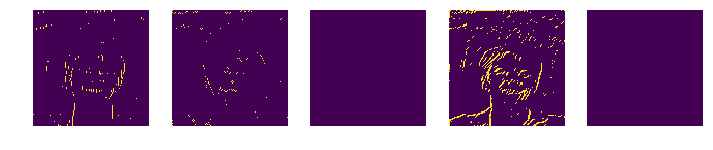

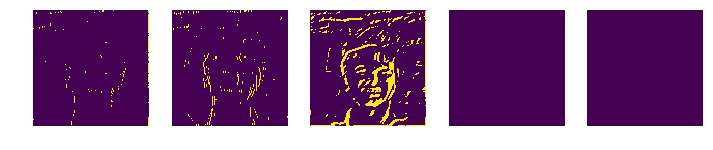

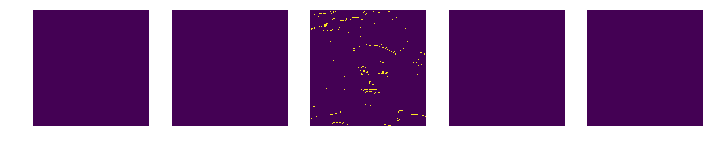

In [19]:
from PIL import Image
import numpy as np

%matplotlib inline

w, h = 112, 112

# Plot helpers
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        print ims.shape
        #if (ims.shape[-1] != 3):
        #    ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
def plots_idx(idx, titles=None):
    plots([features[0][i] for i in idx])

plots_idx(range(0,5))
plots_idx(range(5,10))
plots_idx(range(55,60))


#data = np.zeros((h, w, 3), dtype=np.uint8)
#img = Image.fromarray(features[0][:2028], 'RGB')
#img.show()